In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal as scisig
import pickle

In [137]:
def snr(signal, recon):
    """Returns signal-noise ratio in dB."""
    ratio = np.var(signal)/np.var(signal-recon)
    return 10*np.log10(ratio)
    
# dynamic compressive gammachirp
def dcGC(t,f):
    """Dynamic compressive gammachirp filter as defined by Irino,
    with parameters from Park as used in Charles, Kressner, & Rozell.
    The log term is regularized to log(t + 0.00001).
    t : time in seconds, greater than 0
    f : characteristic frequency in Hz
    One but not both arguments may be numpy arrays.
    """
    ERB = 0.1039*f + 24.7
    return t**3 * np.exp(-2*np.pi*1.14*ERB*t) * np.cos(2*np.pi*f*t + 0.979*np.log(t+0.000001))

# adapted from scipy cookbook
lowcut = 100
highcut = 6000
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = scisig.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = scisig.lfilter(b, a, data)
    return y
    
def plot_spikegram( spikes, sample_rate, markerSize = .0001 ):
    """adapted from https://github.com/craffel/spikegram-coding/blob/master/plotSpikeGram.py"""
    nkernels = spikes.shape[0]
    indices = np.transpose(np.nonzero(spikes))
    scalesKernelsAndOffsets = [(spikes[idx[0],idx[1]], idx[0], idx[1]) for idx in indices]
    
    for scale, kernel, offset in scalesKernelsAndOffsets:
        # Put a dot at each spike location.  Kernels on y axis.  Dot size corresponds to scale
        plt.plot( offset/sample_rate, nkernels-kernel, 'k.', 
                 markersize=markerSize*np.abs( scale ) )
    plt.title( "Spikegram" )
    plt.xlabel( "Time (s)" )
    plt.ylabel( "Kernel" )
    plt.axis( [0.0, spikes.shape[1]/sample_rate, 0.0, nkernels] )
    plt.show()

In [138]:
class SignalSet:
    
    def __init__(self,
                 sample_rate = 16000,
                 data = '../Data/speech_corpora/TIMIT/',
                min_length=800,
                seg_length=8000):
        self.sample_rate = sample_rate
        self.min_length = min_length
        self.seg_length = seg_length
        if isinstance(data, str):
            self.load_from_folder(data)
        else:
            self.data = data
            self.ndata = len(data)            
            
    def load_from_folder(self, folder = '../Data/TIMIT/'):
        min_length = 800 # TODO: should not be hard-coded
        files = os.listdir(folder)
        file = None
        self.data = []
        for ff in files:
            if ff.endswith('.wav'):
                file = os.path.join(folder,ff)
                rate, signal = wavfile.read(file)
                if rate != self.sample_rate:
                    raise NotImplementedError('The signal in ' + ff +
                    ' does not match the given sample rate.')
                if signal.shape[0] > min_length:
                    # bandpass
                    signal = signal/signal.std()
                    signal = butter_bandpass_filter(signal, lowcut, highcut,
                                                    self.sample_rate, order=5)
                    self.data.append(signal)
        self.ndata = len(self.data)
        print("Found ", self.ndata, " files")
        
    def rand_stim(self):
        """Get one random signal."""
        which = np.random.randint(low=0, high=self.ndata)
        signal = self.data[which]
        where = np.random.randint(low=0,high=signal.shape[0]-self.seg_length)
        segment = signal[where:where+self.seg_length]
        segment /= np.max(segment) # norm by max as in Smith & Lewicki
        return signal
        
    def write_sound(self, filename, signal):
        signal /= np.max(signal)
        wavfile.write(filename, self.sample_rate, signal)
        
    def tiled_plot(self, stims):
        """Tiled plots of the given signals. Zeroth index is which signal.
        Kind of slow, expect about 10s for 100 plots."""
        nstim = stims.shape[0]
        plotrows = int(np.sqrt(nstim))
        plotcols = int(np.ceil(nstim/plotrows))
        f, axes = plt.subplots(plotrows, plotcols, sharex=True, sharey=True)
        for ii in range(nstim):
            axes.flatten()[ii].plot(stims[ii])
        f.subplots_adjust(hspace=0, wspace=0)
        plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
        plt.setp([a.get_yticklabels() for a in f.axes[:-1]], visible=False)

In [165]:
class MatchingPursuer:
    
    def __init__(self,
                 data = '../Data/TIMIT/',
                 data_dim=1,
                 nunits = 32,
                 filter_time = 0.05,
                 learn_rate = 0.01,
                 thresh = 0.5,
                 normed_thresh = None,
                 max_iter = 100,
                 min_spike = 0.1,
                 mask_epsilon = None,
                 sample_rate = 16000,
                 use_gammachirps=True,
                 paramfile= 'dummy'):    
        
        self.thresh = thresh
        self.min_spike = min_spike
        self.sample_rate = sample_rate
        self.nunits = nunits
        self.lfilter = int(filter_time * self.sample_rate)
        self.normed_thresh = normed_thresh or 2/np.sqrt(self.lfilter)
        self.mask_epsilon = mask_epsilon or 0.01*np.sqrt(1/self.lfilter)
        self.max_iter = max_iter
        self.data_dim = data_dim
        self.learn_rate = learn_rate
        
        if isinstance(data, str):
            self.stims = SignalSet(data=data)
        else:
            self.stims = data
        
        self.phi = self.initial_filters(gammachirp=use_gammachirps)
        self.graph_dict = self.build_graph()
        
    def initial_filters(self, gammachirp=False):
        """If 1D, Return either a set of gammachirp filters or random (normal) filters,
        normalized. Otherwise return Gaussian noise, not normalized."""
        if self.data_dim==1:
            if gammachirp:
                gammachirps = np.zeros([self.nunits, self.lfilter])
                freqs = np.logspace(np.log10(100), np.log10(6000), self.nunits)
                times = np.linspace(0,self.lfilter/self.sample_rate,self.lfilter)
                for ii in range(self.nunits):
                    gammachirps[ii] = dcGC(times, freqs[ii])
                filters= gammachirps        
            else:
                filters = tf.random_normal([self.nunits, self.lfilter])
            filters /= np.linalg.norm(filters,axis=1)[:,None]
            return filters.reshape(filters.shape+(1,))
        elif self.data_dim>2:
            normal = tf.random_normal([self.nunits, self.lfilter, self.nfreqs])
            return normal
        
    def build_graph(self):
        g = tf.Graph()
        
        with g.as_default():
            
            x = tf.placeholder(tf.float32,
                               shape=[1,None,self.data_dim,1],
                               name='input_signal')
            phi = tf.Variable(self.phi, dtype=tf.float32)
            
            phi_for_conv = tf.transpose(phi, [1,2,0])
            phi_for_conv = tf.expand_dims(phi_for_conv,2)
            
            rev_phi = tf.reverse(phi, dims=[False, True, False])
            phi_for_deconv = tf.transpose(rev_phi, [1,0,2])
            
            with tf.variable_scope('inference'):                
                convs = tf.nn.convolution(x,
                                      phi_for_conv,
                                      padding="VALID", name='convolutions') 
                
            coeffs = tf.placeholder(tf.float32,
                                    shape=[1,None,self.nunits],
                                    name='coefficients')
                
            with tf.variable_scope('learning'):
                xhat = tf.nn.convolution(coeffs, 
                         phi_for_deconv,
                         padding="VALID")
                resid = x - tf.expand_dims(xhat,3)
                mse = tf.reduce_mean(tf.square(resid))
                loss = 0.5*mse
                learner = tf.train.GradientDescentOptimizer(self.learn_rate)
                learn_op = learner.minimize(loss,
                                            var_list = [phi])
                normalize = phi.assign(tf.nn.l2_normalize(phi, dim=1)) # TODO: generalize for 2D data
            
            d = {'g' : g,
                'x' : x,
                'convs': convs,
                'xhat': xhat,
                'coeffs': coeffs,
                'resid': resid,
                'mse' : mse,
                'loss' : loss,
                'learn_op' : learn_op,
                'normalize': normalize}
            return d
        
    def infer(self, signal):
        gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)
        config = tf.ConfigProto(gpu_options=gpu_options)
        with tf.Session(graph=self.graph_dict['g'],
                        config=config) as sess:
            # some stuff here to initialize graph
            sess.run(tf.global_variables_initializer())
            coeffs, xhat, resid, errors = self._infer(signal, sess)
        return coeffs, xhat, resid, errors
        
    def _infer(self, signal, sess):
        signal = signal.reshape([1,-1,self.data_dim,1])
        resid = np.concatenate([signal,
                                np.zeros([1,self.lfilter-1,self.data_dim,1])],
                               axis=1)
        d = self.graph_dict
        coeffs = np.zeros([1,signal.shape[1]+self.lfilter-1,self.nunits])
        
        errors = []
        
        cond = True
        iter_count = 0
        while cond:
            convs = sess.run(d['convs'], feed_dict={d['x'] : resid})
            winner = np.unravel_index(convs.argmax(), convs.shape)
            coeffswinner = [winner[0], winner[1], winner[3]]
            coeffswinner[1] += self.lfilter - 1
            coeffswinner = tuple(coeffswinner)
            if coeffs[coeffswinner] != 0:
                print('Tried to use a coefficient twice. Breaking.')
                cond = False
            spike = convs[winner]
            iter_count += 1
            if spike < self.min_spike or iter_count>self.max_iter:
                cond=False
            if cond:
                coeffs[coeffswinner] = convs[winner]
                feed_dict = {d['x'] : signal,
                            d['coeffs'] : coeffs}
                resid, mse, xhat = sess.run([d['resid'], d['mse'], d['xhat']],
                                 feed_dict=feed_dict)
                errors.append(mse)
        return coeffs, xhat, resid, np.array(errors)
    
    def train(self, ntrials=100):
        gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)
        config = tf.ConfigProto(gpu_options=gpu_options)
        losses = np.zeros(ntrials)
        d = self.graph_dict
        with tf.Session(graph=d['g'],
                        config=config) as sess:
            # some stuff here to initialize graph
            sess.run(tf.global_variables_initializer())
            for ii in range(ntrials):
                signal = self.stims.rand_stim()
                coeffs, xhat, resid, errors = self._infer(signal, sess)
                feed_dict = {d['coeffs'] : coeffs,
                            d['x'] : signal.reshape([1,-1,self.data_dim,1])}
                mse, _ = sess.run([d['mse'],d['learn_op']],
                                      feed_dict=feed_dict)
                losses[ii] = mse*signal.shape[0]/np.linalg.norm(signal)**2
                sess.run(d['normalize'])
        return losses

# Testing inference

In [5]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20,10)

In [140]:
data = SignalSet()

Found  6292  files


In [8]:
sig = data.rand_stim()

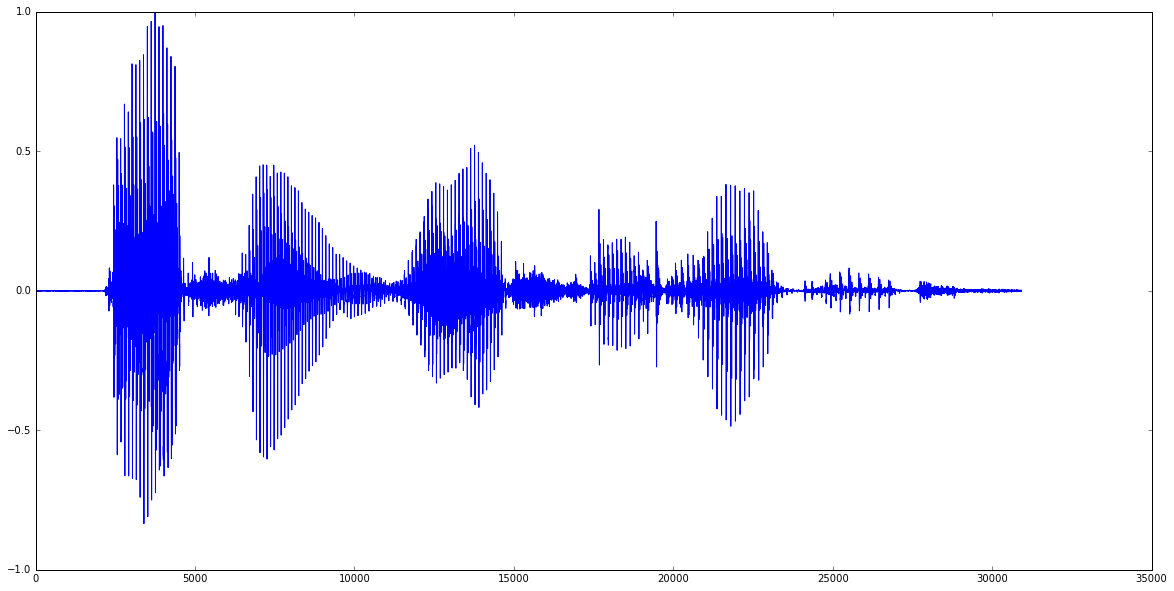

In [9]:
plt.plot(sig)

In [58]:
segment = sig[2000:10000]

In [166]:
mp = MatchingPursuer(data=data)

In [125]:
coeffs, xhat, resid, errors = mp.infer(segment)

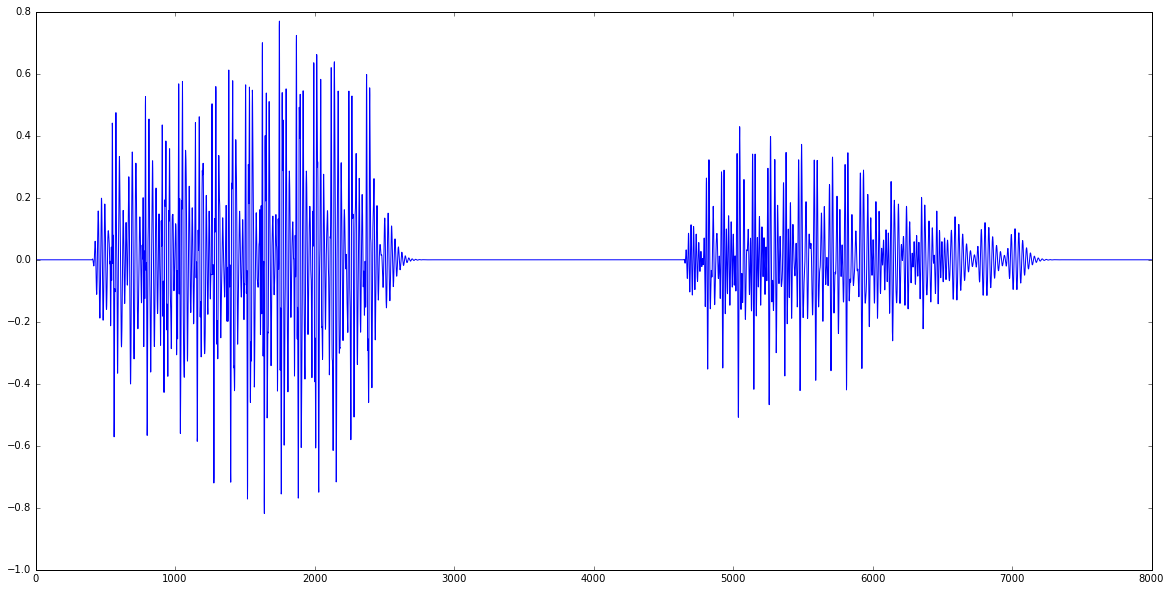

In [126]:
plt.plot(np.squeeze(xhat))

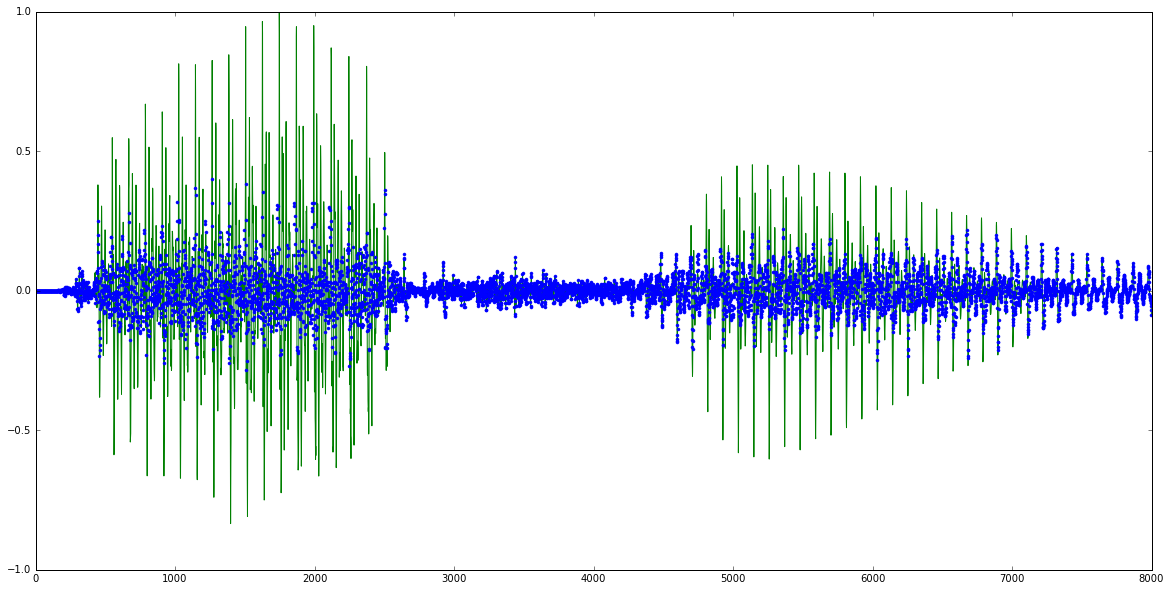

In [120]:
plt.plot(segment,'g',np.squeeze(resid),'b.')

In [158]:
mp.max_iter = 20
coeffs, xhat, resid, errors = mp.infer(segment)

In [163]:
segnorm = np.linalg.norm(segment)
segnorm

14.265727189683018

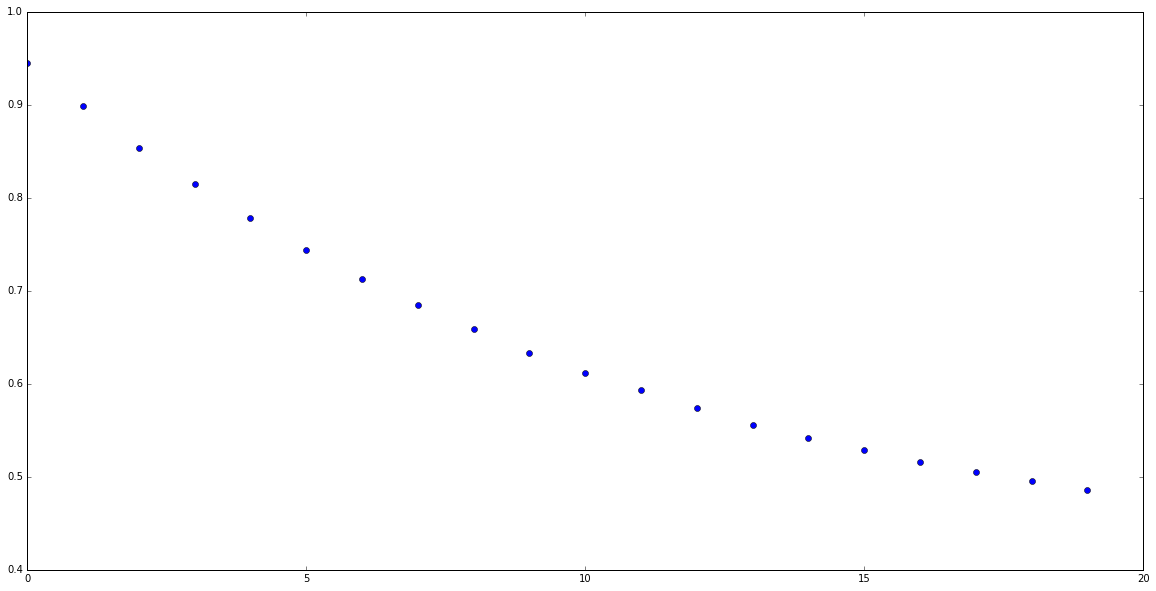

In [164]:
plt.plot([er*segment.shape[0]/segnorm**2 for er in errors],'bo')

# Testing learning

In [167]:
losses = mp.train(ntrials=2)

In [168]:
losses

array([ 0.38963338,  0.39060214])

In [169]:
np.linalg.norm(mp.phi[0])

1.0

# Testing the .py

In [2]:
import sys
sys.path.append('..')
import matchingpursuit
import signalset
import imp
imp.reload(matchingpursuit)

<module 'matchingpursuit' from '..\\matchingpursuit.py'>

In [3]:
sigset = signalset.SignalSet(data='../../Data/speech_corpora/TIMIT/')
signal = sigset.rand_stim()
signal.shape

Found  6292  files


(8000,)

In [4]:
mp = matchingpursuit.MatchingPursuer(sigset, use_gammachirps=False)

In [5]:
mp.max_iter = 2
mp.train(2)

0


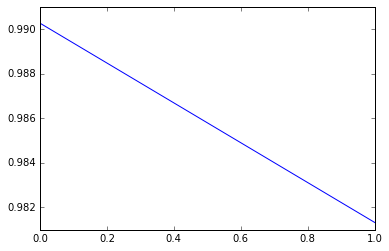

In [6]:
import matplotlib.pyplot as plt
plt.plot(mp.losshistory)
plt.show()

In [7]:
mp.max_iter = 10
coeffs, xhat, resid, errors = mp.infer(signal)

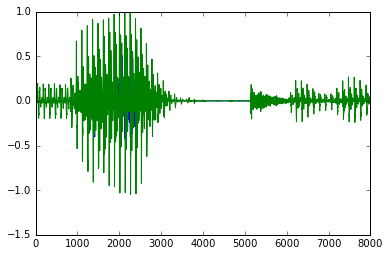

In [9]:
plt.plot(np.squeeze(xhat), 'b', signal, 'g')
plt.show()

In [26]:
signal = sigset.rand_stim()
signal.shape

(40953,)

In [27]:
sigset.seg_length

8000